# 01: Data Exploration

This notebook serves as an overview of Python packages and their dependencies. Together, they form a directed graph: the nodes are packages with metadata as features while the edges point from dependents to their dependencies.

Beyond simply loading the data and exploring these elements as is, the groundwork is laid for two important types of feature engineering.

1. *Structural features*: The first involves the creation and visualization of structural features that describe patterns in dependencies. While the deep learning approaches to be applied later naturally appreciate structural information encoded in graphs, other more traditional methods of anomaly detection stand to benefit from the extra effort.

2. *Anomaly detection behavior*: Secondly, the exponential nature of package success poses a problem to anomaly detection; without some form of transformation, the exceptionally popular and maintained projects will stand out as anomalous.

To understand the data and instead highlight projects with particularly unusual patterns in documentation, maintainence, and dependency structure, a selection of the most popular and most recently uploaded packages are compared here.

## **Setup**

### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from data.load import load_and_verify_graph

### Plotting Prep

In [2]:
color_top = "slateblue"
color_recent = "lightcoral"
colors = [color_top, color_recent]

def add_grid(ax, axis="x"):
    ax.set_axisbelow(True)
    ax.grid(axis=axis,  alpha=0.5)

## **Load Data**

### Load and Verify

In [3]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME = "graph_top_n500_20250729"
G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_top_n500_20250729':
  1,248 nodes
  500 core packages
  3,633 dependencies
  directed=True

Sample node metadata:
  pytest-cov: SourceRank=26, stars=1918, forks=217
  uv: SourceRank=22, stars=62605, forks=1800
  markupsafe: SourceRank=22, stars=636, forks=156
  apache-airflow-providers-common-sql: SourceRank=20, stars=41273, forks=15377
  rpds-py: SourceRank=19, stars=52, forks=22

Sample edge metadata:
  pytest-cov -> coverage: kind=runtime, optional=False
  pytest-cov -> pluggy: kind=runtime, optional=False
  pytest-cov -> pytest: kind=runtime, optional=False
  pytest-cov -> fields: kind=testing, optional=True
  pytest-cov -> hunter: kind=testing, optional=True


In [4]:
RECENT_GRAPH_NAME = "graph_recent_n500_20250729"
G_recent, df_edges_recent = load_and_verify_graph(RECENT_GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_recent_n500_20250729':
  2,105 nodes
  500 core packages
  4,802 dependencies
  directed=True

Sample node metadata:
  thoa: SourceRank=3, stars=0, forks=0
  pyninja-tool: SourceRank=5, stars=0, forks=0
  tobiko-cloud-pydantic: SourceRank=4, stars=0, forks=0
  karrio-boxknight: SourceRank=10, stars=625, forks=134
  dapr-agents: SourceRank=9, stars=253, forks=135

Sample edge metadata:
  pyninja-tool -> aiohttp: kind=runtime, optional=False
  pyninja-tool -> click: kind=runtime, optional=False
  pyninja-tool -> packaging: kind=runtime, optional=False
  pyninja-tool -> requests: kind=runtime, optional=False
  pyninja-tool -> rich: kind=runtime, optional=False


### Missing Metadata

In [5]:
def show_nodes_with_missing_metadata(G, max_display=20, remove=False):
    missing_metadata_nodes = [node for node, data in G.nodes(data=True) if data.get('missing_metadata')]

    if missing_metadata_nodes:
        print(f"Nodes with missing metadata: {len(missing_metadata_nodes):,}")
        print("-" * 40)
        for i, node in enumerate(missing_metadata_nodes[:max_display], 1):
            print(f"{i:3d}. {node}")
        if len(missing_metadata_nodes) > max_display:
            print(f"... and {len(missing_metadata_nodes) - max_display} more.")
        print("-" * 40)
        if remove:
            G.remove_nodes_from(missing_metadata_nodes)
            print(f"Removed {len(missing_metadata_nodes):,} nodes with missing metadata.")
    else:
        print("All nodes have complete metadata.")

print("Top packages graph:")
show_nodes_with_missing_metadata(G_top, remove=True)
print()
print("Recent packages graph:")
show_nodes_with_missing_metadata(G_recent, remove=True)

Top packages graph:
All nodes have complete metadata.

Recent packages graph:
Nodes with missing metadata: 4
----------------------------------------
  1. invoicing-pdf99
  2. yandex-robotics-trt-inference-cuda
  3. sicar
  4. thds-termtool
----------------------------------------
Removed 4 nodes with missing metadata.


## **Graph Visualization**

### Top Packages

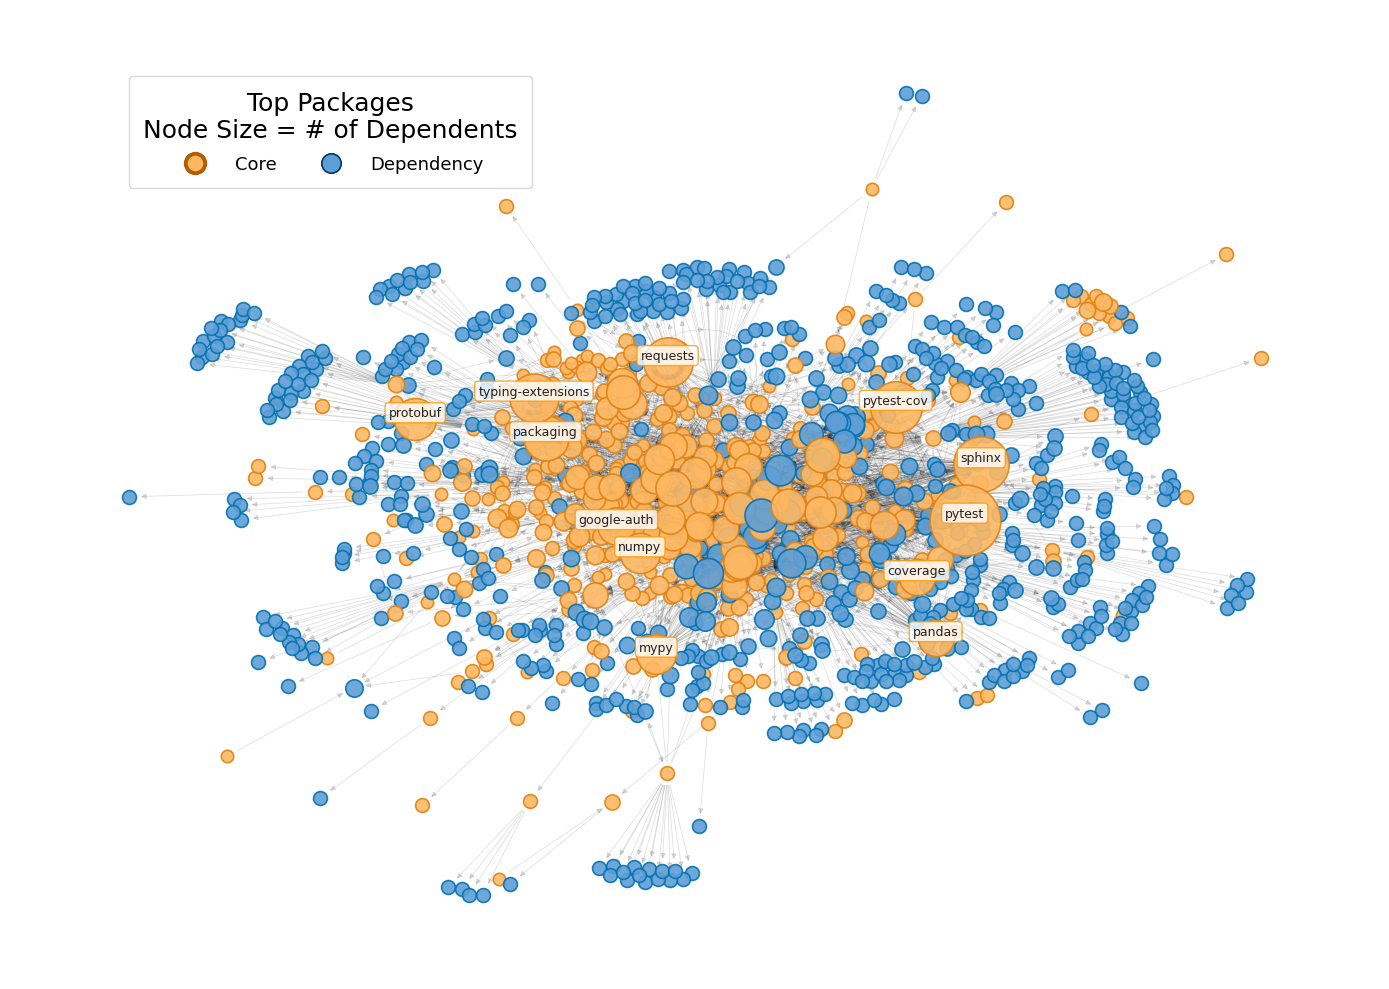

In [6]:
def plot_core_dependency_graph(G, title, max_labels=12, bbox_to_anchor=(0.08, 0.92)):
    # Find largest connected component
    comps = list(nx.weakly_connected_components(G) if nx.is_directed(G) else nx.connected_components(G))
    if not comps:
        print("No connected components found."); return
    G_sub = G.subgraph(max(comps, key=len)).copy()

    # Identify core nodes and compute node sizes
    core_nodes = [n for n, d in G_sub.nodes(data=True) if d.get("is_core", False)]
    in_deg = dict(G_sub.in_degree())
    min_deg, max_deg = (min(in_deg.values()), max(in_deg.values())) if in_deg else (0, 1)
    get_size = lambda n, mi=80, ma=2600: (mi+ma)//2 if max_deg==min_deg else mi+(ma-mi)*(in_deg.get(n,0)-min_deg)/(max_deg-min_deg)
    node_sizes = {n: get_size(n) for n in G_sub.nodes()}
    sorted_nodes = sorted(G_sub.nodes(), key=lambda n: node_sizes[n])

    # Set node and edge colors/styles
    core_color, dep_color = "#fdb863", "#5e9fd6"
    node_colors = [core_color if n in core_nodes else dep_color for n in sorted_nodes]
    node_edgecolors = ["#e08214" if n in core_nodes else "#0571b0" for n in sorted_nodes]
    node_linewidths = [1.2 for _ in sorted_nodes]
    node_alphas = [0.9 for _ in sorted_nodes]

    # Compute node positions (layout)
    if G_sub.number_of_nodes() <= 1:
        pos = {n: (0, 0) for n in G_sub.nodes()}
    else:
        pos = nx.spring_layout(G_sub, k=1.0/np.sqrt(G_sub.number_of_nodes()), iterations=200, seed=42, scale=1.5)
        if core_nodes:
            top_label_nodes = sorted(core_nodes, key=lambda n: in_deg.get(n,0), reverse=True)[:max_labels]
            angle_step, radius = 2*np.pi/max(1,len(top_label_nodes)), 0.45
            centroid = np.mean(list(pos.values()), axis=0)
            for i, n in enumerate(top_label_nodes):
                angle = i*angle_step
                direction = np.array([np.cos(angle), np.sin(angle)])
                pos[n] = tuple(centroid + (np.array(pos[n])-centroid)*1.18 + direction*radius)

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_edges(G_sub, pos, alpha=0.13, arrowsize=8, width=0.55)
    for idx, n in enumerate(sorted_nodes):
        nx.draw_networkx_nodes(G_sub, pos, nodelist=[n], node_color=node_colors[idx], node_size=node_sizes[n],
                              edgecolors=node_edgecolors[idx], linewidths=node_linewidths[idx],
                              alpha=node_alphas[idx], node_shape="o")

    # Draw labels for top core nodes
    if core_nodes:
        top_label_nodes = sorted(core_nodes, key=lambda n: in_deg.get(n,0), reverse=True)[:max_labels]
        for i, n in enumerate(top_label_nodes):
            x, y = pos[n]
            plt.text(x, y, n, fontsize=9, color="#222", ha="center", va="bottom",
                     bbox=dict(facecolor="white", edgecolor="#ff9800", alpha=0.8, boxstyle="round,pad=0.28"))

    # Add legend and finalize plot
    plt.axis("off")
    leg = plt.legend(
        handles=[
            Line2D([0], [0], marker="o", color="w", label="Core", markerfacecolor=core_color, markeredgecolor="#b35c00", markersize=14, linewidth=0, markeredgewidth=2.8),
            Line2D([0], [0], marker="o", color="w", label="Dependency", markerfacecolor=dep_color, markeredgecolor="#003366", markersize=14, linewidth=0, markeredgewidth=1.2)
        ],
        title=title, title_fontsize=18, scatterpoints=1, loc="upper left", bbox_to_anchor=bbox_to_anchor,
        ncol=2, frameon=True, fontsize=13, handletextpad=1.2, borderpad=0.8, labelspacing=0.7, fancybox=True
    )
    if leg.get_title() is not None:
        leg.get_title().set_ha("center")
    plt.tight_layout()
    plt.show()

plot_core_dependency_graph(G_top, "Top Packages\nNode Size = # of Dependents", max_labels=12, bbox_to_anchor=(0.08, 0.94))

### Recent Packages

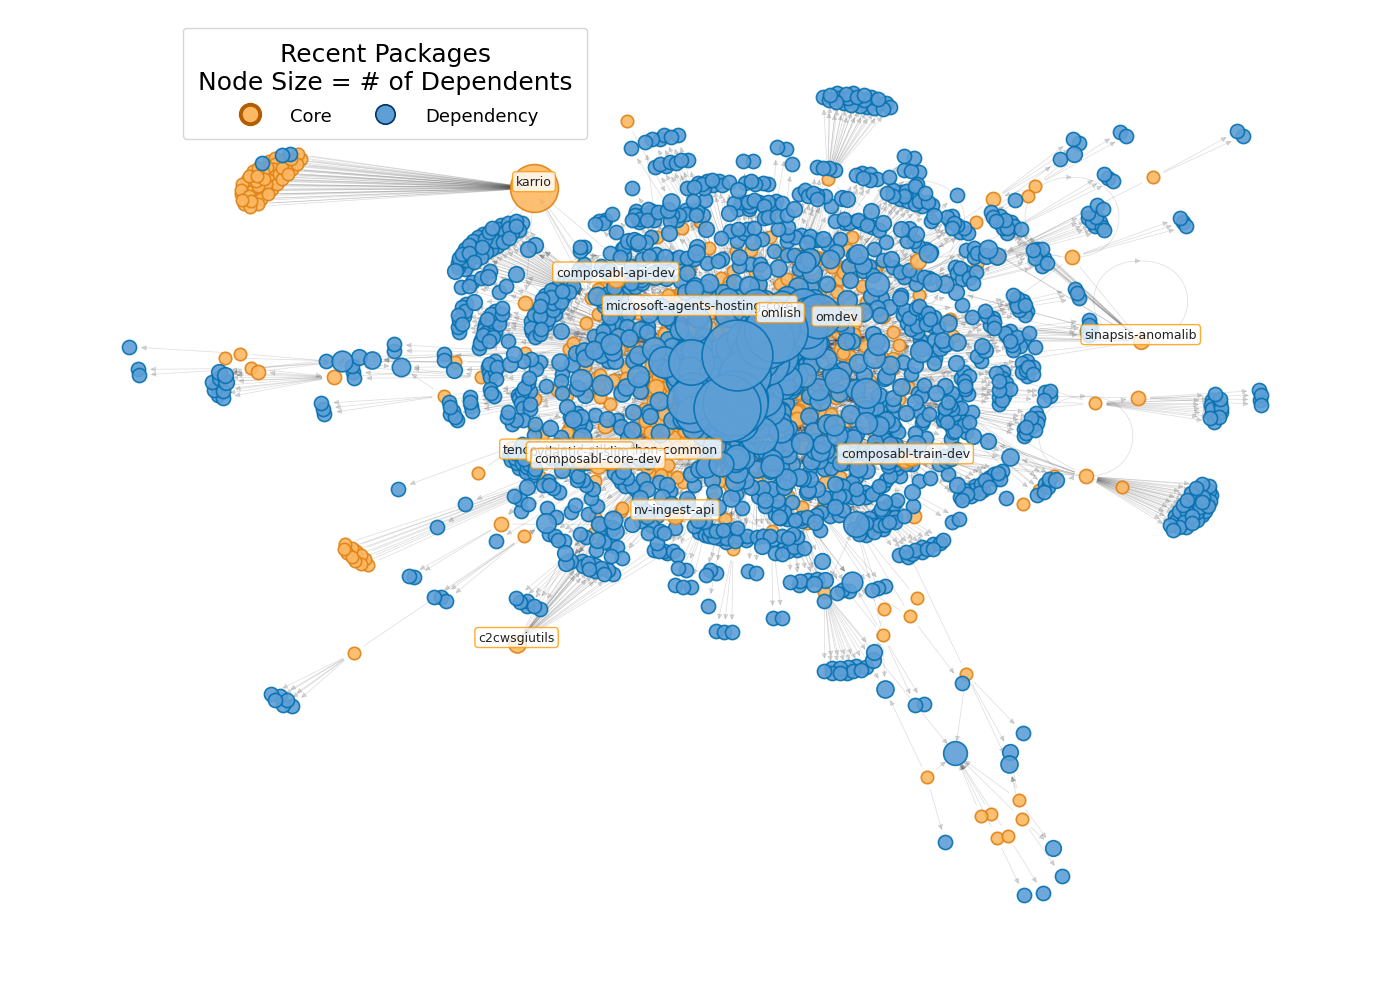

In [7]:
plot_core_dependency_graph(G_recent, "Recent Packages\nNode Size = # of Dependents", bbox_to_anchor=(0.12, 0.99))

## **Projects (Nodes)**

### Extract Node Features

In [8]:
def get_core_nodes_df(G):
    df = pd.DataFrame([
        {"name": node, **data}
        for node, data in G.nodes(data=True) if data.get("is_core")
    ])
    if "latest_release" in df.columns:
        df["latest_release"] = pd.to_datetime(df["latest_release"], errors="coerce")
    return df

df_nodes_top = get_core_nodes_df(G_top)
df_nodes_recent = get_core_nodes_df(G_recent)

### Package Popularity

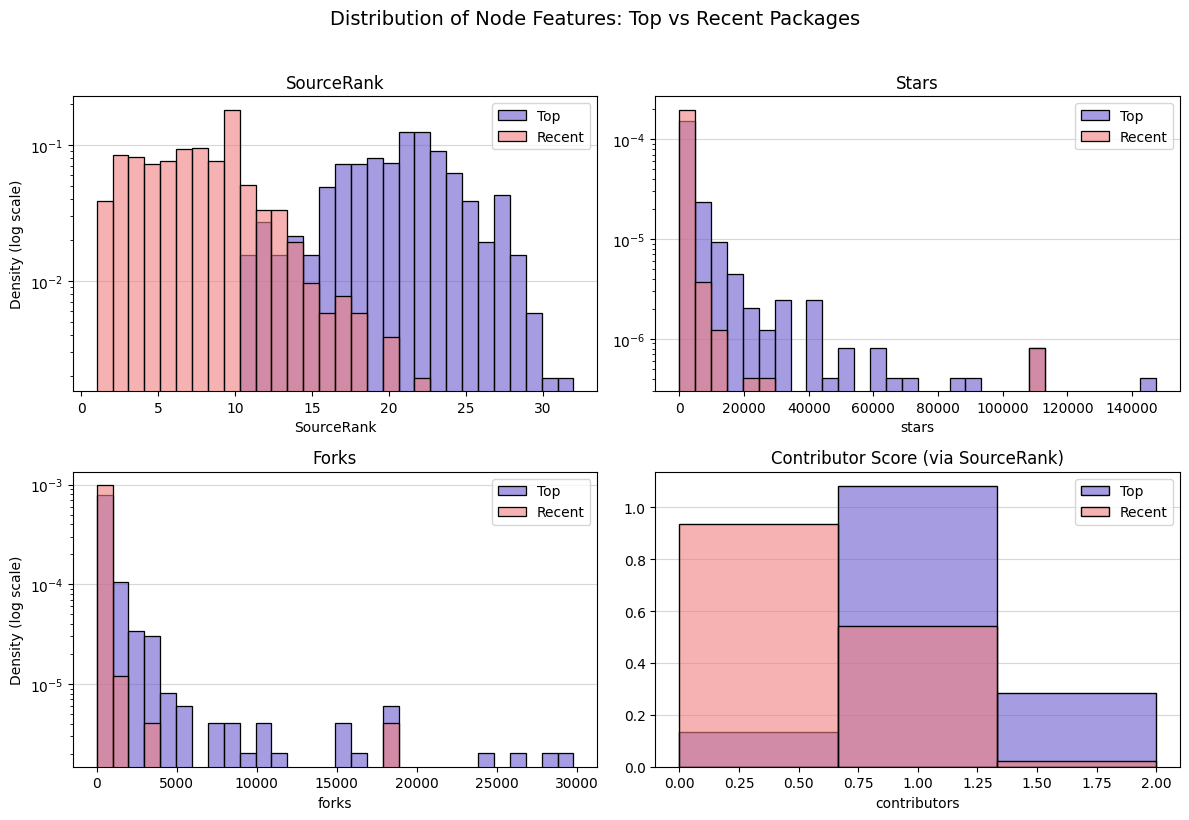

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

features = ["SourceRank", "stars", "forks", "contributors"]
titles = ["SourceRank", "Stars", "Forks", "Contributor Score (via SourceRank)"]

for i, feature in enumerate(features):
    data_top = df_nodes_top[feature]
    data_recent = df_nodes_recent[feature]
    data_all = pd.concat([data_top, data_recent])
    min_val = data_all.min()
    max_val = data_all.max()

    if feature == "contributors":
        bins = 3
    else:
        bins = 30
        bin_width = (max_val - min_val) / bins if max_val > min_val else 1
        bins = np.arange(min_val, max_val + bin_width, bin_width)
        axes[i].set_yscale("log")

    sns.histplot(data_top, bins=bins, color=colors[0], label="Top", ax=axes[i], alpha=0.6, stat="density")
    sns.histplot(data_recent, bins=bins, color=colors[1], label="Recent", ax=axes[i], alpha=0.6, stat="density")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(feature)
    if i % 2 == 0:
        axes[i].set_ylabel("Density (log scale)")
    else:
        axes[i].set_ylabel("")
    axes[i].legend()
    add_grid(axes[i], "y")

fig.suptitle("Distribution of Node Features: Top vs Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

> The disparity between top and recent packages is clear, but the rarity of high stars, forks, and contributor scores indicate a likelihood that top packages will be marked anomalous by unwitting models.
>
> However, of even greater concern is the number of samples with exactly 0 stars or forks; even with a transformation, the discriminative power in the context of anomaly detection will be limited. This can be seen by applying the following log reciprocal transformation to the potential input features:
>
> ![LogReciprocal](../assets/img/log_reciprocal.png)

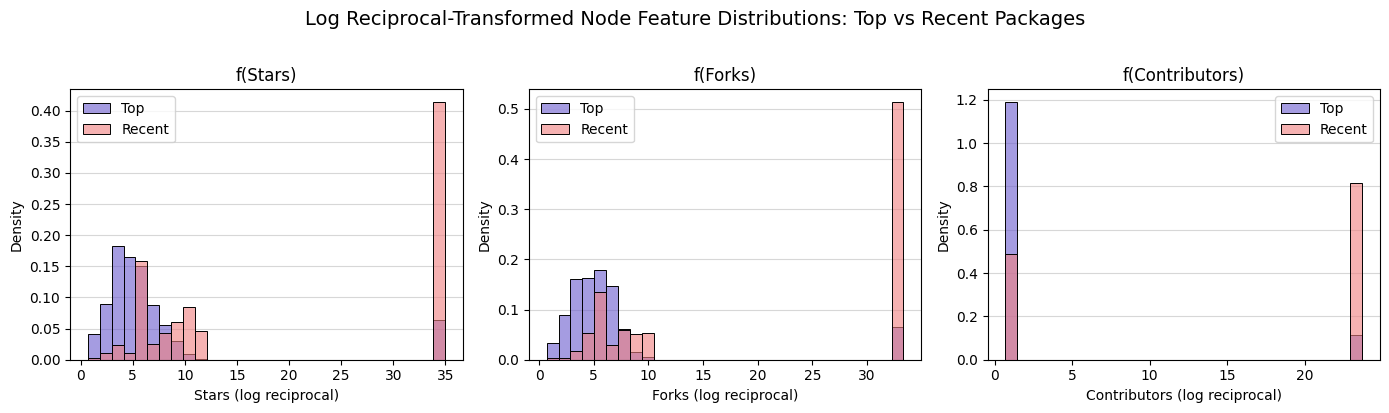

In [10]:
def log_reciprocal(x, global_max, normalize=False):
    eps = 1e-10
    result = np.log1p(global_max / (x + eps))
    if normalize:
        result = (result - result.min()) / (result.max() - result.min())
    return result

F = log_reciprocal
features_to_transform = ["stars", "forks", "contributors"]
titles = [
    "f(Stars)",
    "f(Forks)",
    "f(Contributors)"
]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Use a consistent number of bins for all histograms
num_bins = 30

for i, feature in enumerate(features_to_transform):
    global_max = df_nodes_top[feature].max()

    # Apply the log reciprocal transformation to both top and recent package features
    data_top = F(df_nodes_top[feature], global_max)
    data_recent = F(df_nodes_recent[feature], global_max)
    data_all = pd.concat([data_top, data_recent])
    min_val = data_all.min()
    max_val = data_all.max()

    # Use the same bin edges for both top and recent for this feature
    bins = np.linspace(min_val, max_val, num_bins + 1)

    sns.histplot(data_top, bins=bins, color=colors[0], label="Top", ax=axes[i], alpha=0.6, stat="density")
    sns.histplot(data_recent, bins=bins, color=colors[1], label="Recent", ax=axes[i], alpha=0.6, stat="density")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(f"{feature.capitalize()} (log reciprocal)")
    axes[i].set_ylabel("Density")
    axes[i].legend()
    add_grid(axes[i], "y")

fig.suptitle("Log Reciprocal-Transformed Node Feature Distributions: Top vs Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


> The isolated spikes indicate projects where the raw values are exactly zero. This is a common enough phenomenon to render these features less useful when used directly as drivers of anomalies.
>
> However, there is important information here; popular repositories are unlikely to be anomalous when defined as suspicious. In other words, they are rare but benign. Consequently, we may consider them as filtering or negative indicators.

### License Types

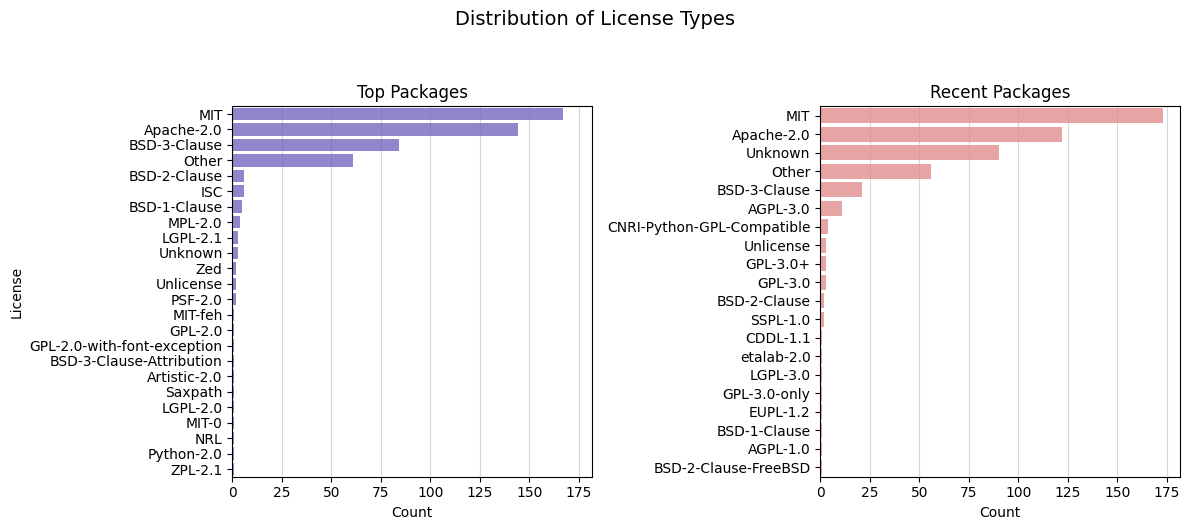

In [11]:
# Plot and compare license value counts for df_nodes_top and df_nodes_recent
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Top packages
license_counts_top = df_nodes_top["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_top.values, y=license_counts_top.index, ax=axes[0], color=color_top, alpha=0.8)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("License")

# Recent packages
license_counts_recent = df_nodes_recent["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_recent.values, y=license_counts_recent.index, ax=axes[1], color=color_recent, alpha=0.8)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

for ax in axes:
    add_grid(ax)

fig.suptitle("Distribution of License Types", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

> Intuitively, being unlicensed may be cause for greater suspicion. Fortunately, the SourceRank data has a license_present feature. See just below.

### SourceRank Metrics

> SourceRank is a proprietary score asssigned to packages by Libraries.io. While it is not to be used as input for the presently discussed anomaly detection models due to its inherently opinionated nature, it will serve well as informal comparison point.
>
> Moreover, Libraries.io offers many metrics used to compute source rank. Below is a look at them.

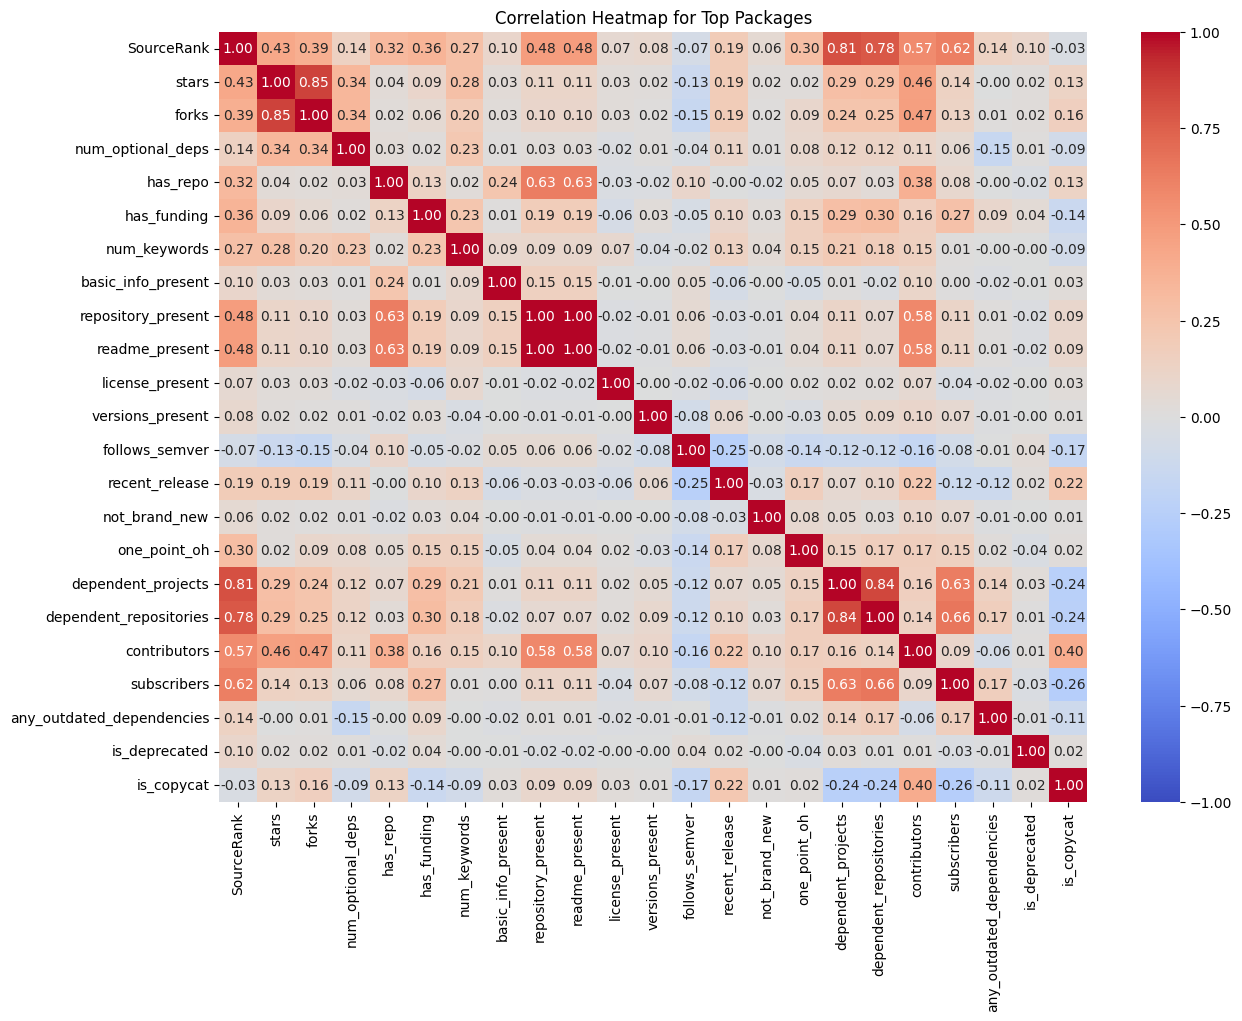

In [12]:
def plot_correlation_heatmap(df, title, figsize=(14, 10)):
    # Select numeric columns, including bool as 0/1
    numeric_cols = df.select_dtypes(include=["int64", "float64", "bool"]).copy()
    for col in numeric_cols.select_dtypes(include=["bool"]).columns:
        numeric_cols[col] = numeric_cols[col].astype(int)
    corr = numeric_cols.corr().dropna(axis=0, how="all").dropna(axis=1, how="all")
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

plot_correlation_heatmap(df_nodes_top, "Correlation Heatmap for Top Packages")

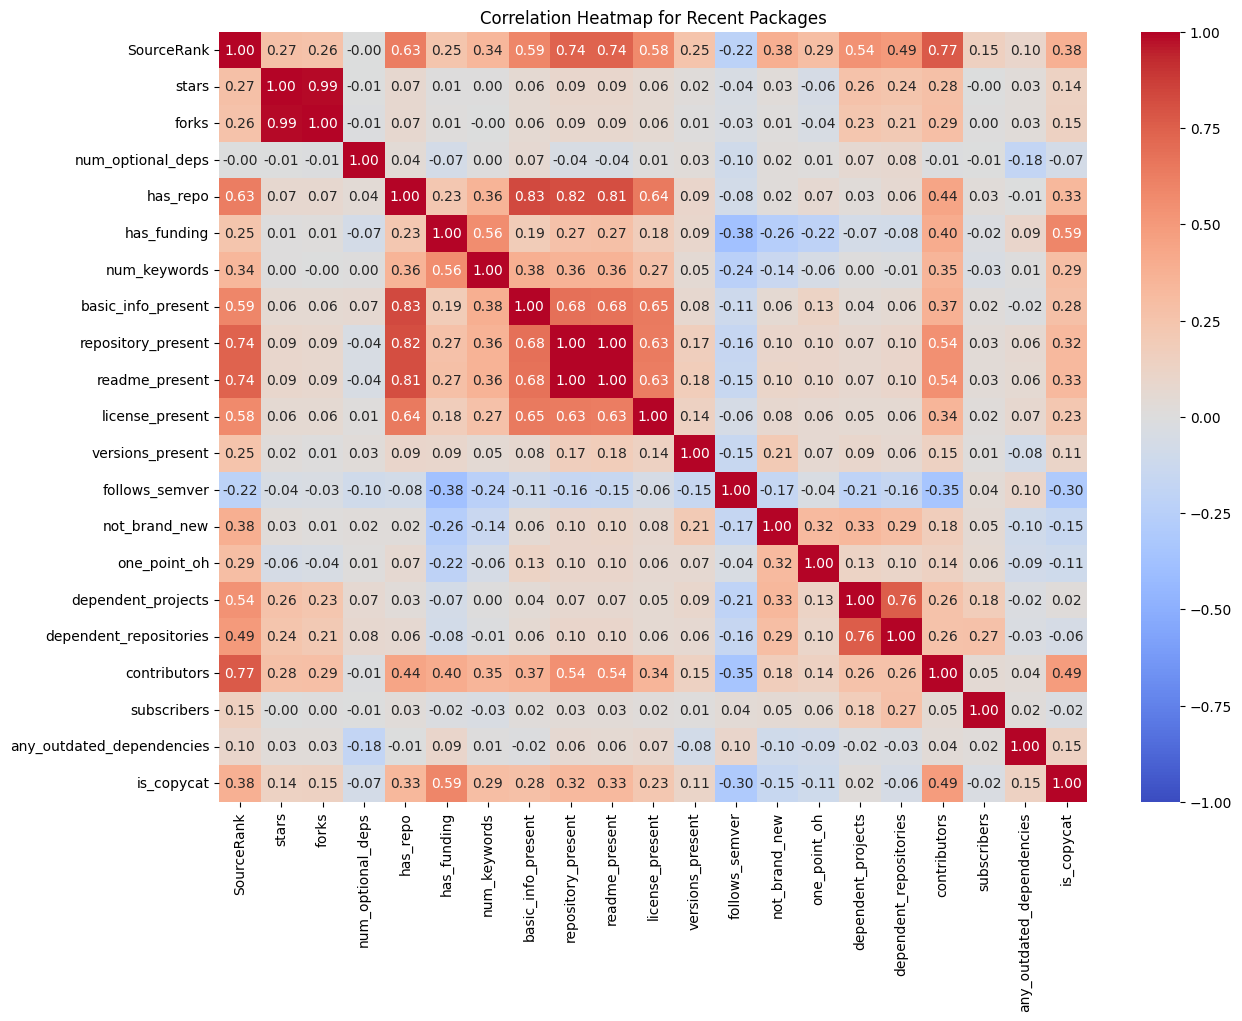

In [13]:
plot_correlation_heatmap(df_nodes_recent, "Correlation Heatmap for Recent Packages")

> There are a lot of weak and moderate linear correlations with SourceRank. The presence of a readme and number of contributers seem to be of particular interest.
>
> Also of note is the colinearity of stars and forks as well as repository_present and readme_present; likely only one of each is necessary.

### Copycats (Projects in Same Repo)

In [14]:
def get_copycat_repo_details(df):
    copycats = df[(df["is_copycat"])]
    if copycats.empty:
        return copycats

    # Group by repo_url and aggregate details
    grouped = (
        copycats
        .groupby("repo_url", as_index=False)
        .agg(
            count=("name", "size"),
            name=("name", lambda x: ", ".join(sorted(set(x)))),
            stars=("stars", "max"),
            forks=("forks", "max")
        )
        .sort_values(["count", "repo_url"], ascending=[False, True])
    )
    return grouped

top_copycat_details = get_copycat_repo_details(df_nodes_top)
recent_copycat_details = get_copycat_repo_details(df_nodes_recent)

print("Top packages with shared repository url and metadata:")
display(top_copycat_details)

print("\nRecent packages with shared repository url and metadata:")
display(recent_copycat_details)

Top packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
3,https://github.com/googleapis/google-cloud-python,16,"google-analytics-admin, google-cloud-appengine...",5075,1590
6,https://github.com/open-telemetry/opentelemetr...,9,"opentelemetry-api, opentelemetry-exporter-otlp...",2068,717
0,https://github.com/Azure/azure-sdk-for-python,7,"azure-common, azure-core, azure-identity, azur...",5008,3060
8,https://github.com/python/typeshed,4,"types-protobuf, types-python-dateutil, types-p...",4755,1886
7,https://github.com/open-telemetry/opentelemetr...,3,"opentelemetry-instrumentation, opentelemetry-i...",872,744
1,https://github.com/Legrandin/pycryptodome,2,"pycryptodome, pycryptodomex",3006,538
2,https://github.com/certbot/certbot,2,"acme, certbot-dns-cloudflare",32247,3429
4,https://github.com/grpc/grpc,2,"grpcio, grpcio-tools",43381,10853
5,https://github.com/langchain-ai/langchain,2,"langchain, langchain-core",112416,18356
9,https://github.com/tensorflow/tensorboard,2,"tb-nightly, tensorboard",6942,1674



Recent packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
10,https://github.com/karrioapi/karrio,56,"karrio, karrio-allied-express, karrio-allied-e...",625,134
5,https://github.com/TencentCloud/tencentcloud-s...,13,"tencentcloud-sdk-python, tencentcloud-sdk-pyth...",655,251
12,https://github.com/microsoft/Agents,8,"microsoft-agents-activity, microsoft-agents-au...",355,117
14,https://github.com/wrmsr/omlish,7,"omdev, omdev-cext, omdev-cli, ominfra, omlish,...",4,0
9,https://github.com/karellen/karellen-llvm,5,"karellen-llvm-clang, karellen-llvm-core, karel...",4,0
1,https://github.com/HaizeaAnalytics/terrakio-py...,3,"terrakio-admin-api, terrakio-api, terrakio-core",0,0
2,https://github.com/NVIDIA/nv-ingest,3,"nv-ingest, nv-ingest-api, nv-ingest-client",2724,258
7,https://github.com/TrilliantHealth/trilliant-d...,3,"thds.adls, thds.atacama, thds.core",5,0
8,https://github.com/camptocamp/c2cgeoportal,3,"c2cgeoportal-admin, c2cgeoportal-commons, c2cg...",66,45
13,https://github.com/pydantic/pydantic-ai,3,"pydantic-ai, pydantic-evals, pydantic-graph",11296,1081


> As some projects share the same repo (and therefor features such as stars and forks), there may be some benefit of accounting for this.
>
> While consolidating is one option, creating a boolean feature may prove more convenient.

## **Dependencies (Edges)**

### Common Dependencies

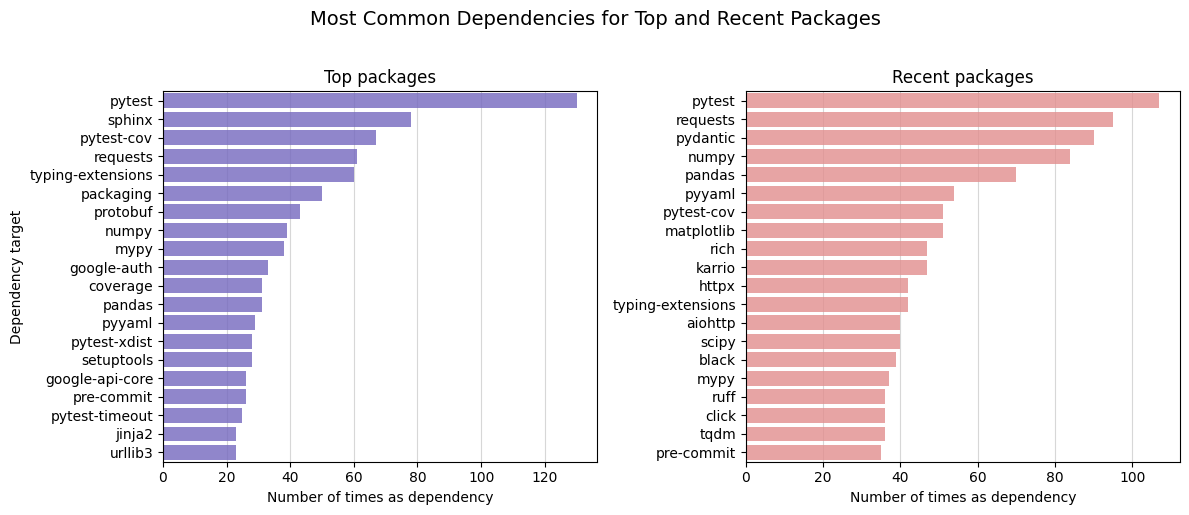

In [15]:
n = 20

top_common_targets = df_edges_top["target"].value_counts().head(n)
recent_common_targets = df_edges_recent["target"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    y=top_common_targets.index,
    x=top_common_targets.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as dependency")
axes[0].set_ylabel("Dependency target")
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_common_targets.index,
    x=recent_common_targets.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as dependency")
axes[1].set_ylabel("")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

fig.suptitle("Most Common Dependencies for Top and Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

> There is likely something useful here in the likely presence of unit testing, documentation, HTTP requests, and other indicators of suspicious activity (or lack thereof). However, this would maybe need a deeper dive later on if deemed to be necessary.

### Dependency Counts

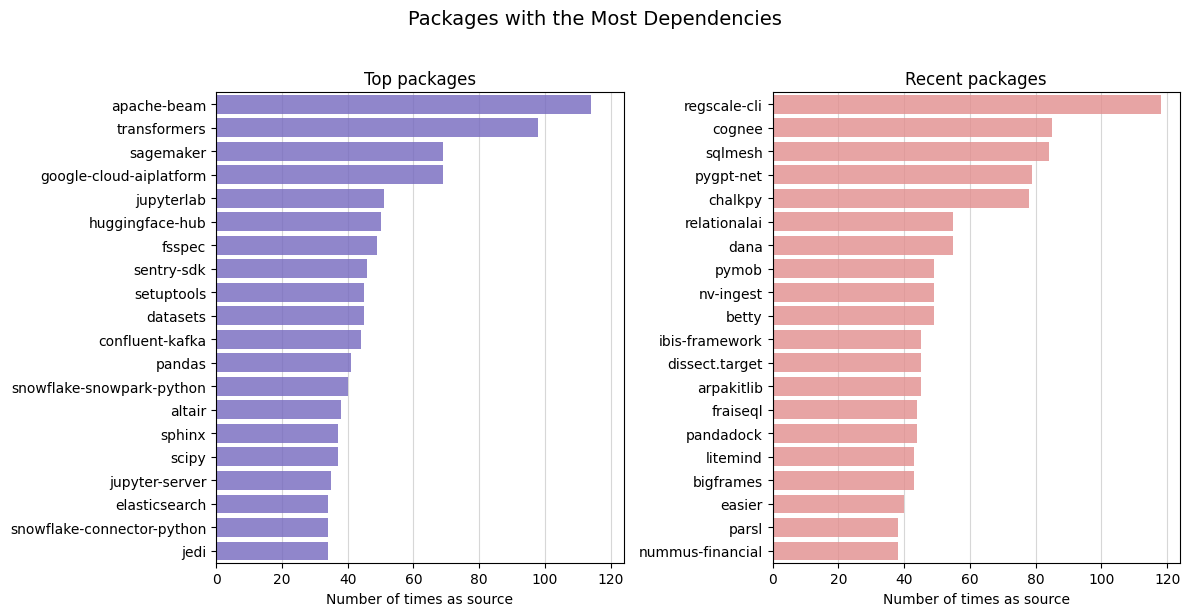

In [16]:
n = 20
top_sources = df_edges_top["source"].value_counts().head(n)
recent_sources = df_edges_recent["source"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.barplot(
    y=top_sources.index,
    x=top_sources.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as source")
axes[0].set_ylabel(None)
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_sources.index,
    x=recent_sources.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as source")
axes[1].set_ylabel(None)
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

# Add grid lines
fig.suptitle("Packages with the Most Dependencies", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

> Neither top or recent packages stand out in terms of their behavior when it comes to large dependency count.
>
> While there may be something to high surface area or obfuscation of suspicious activity with a higher number of dependencies, it is not clear without further analysis.

### Optional Dependency Proportions

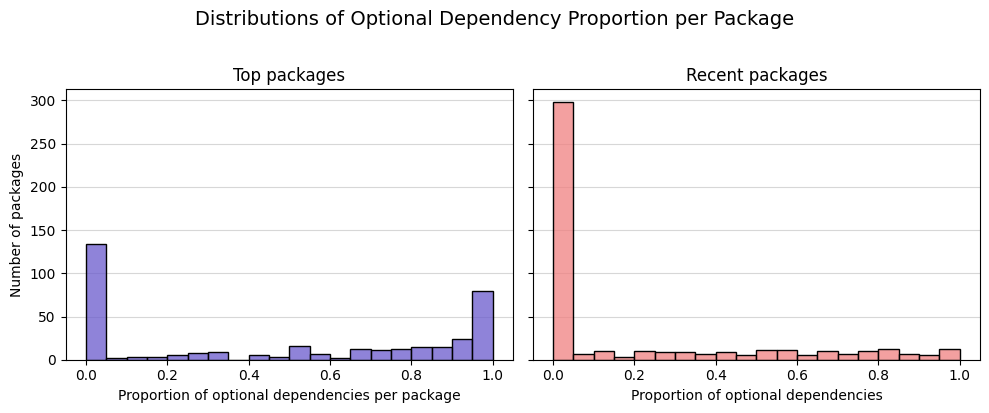

In [17]:
# Compute proportion of optional dependencies per source package for both DataFrames
prop_top = (
    df_edges_top.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)
prop_recent = (
    df_edges_recent.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)

# Top packages
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
sns.histplot(prop_top, bins=20, color=color_top, kde=False, ax=axes[0])
axes[0].set_xlabel("Proportion of optional dependencies per package")
axes[0].set_ylabel("Number of packages")
axes[0].set_title("Top packages")

# Recent packages
sns.histplot(prop_recent, bins=20, color=color_recent, kde=False, ax=axes[1])
axes[1].set_xlabel("Proportion of optional dependencies")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distributions of Optional Dependency Proportion per Package", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

> Recent packages are far more likely to have no dependencies be optional, while top packages tend to be balanced between all or nothing in terms of optional imports.
>
> While both have a majority of packages not specifying any dependencies as optional, a value of 0.0 may be yet another weak indicator of a less sound project.

## **Graph Structure**

### Degree Distributions

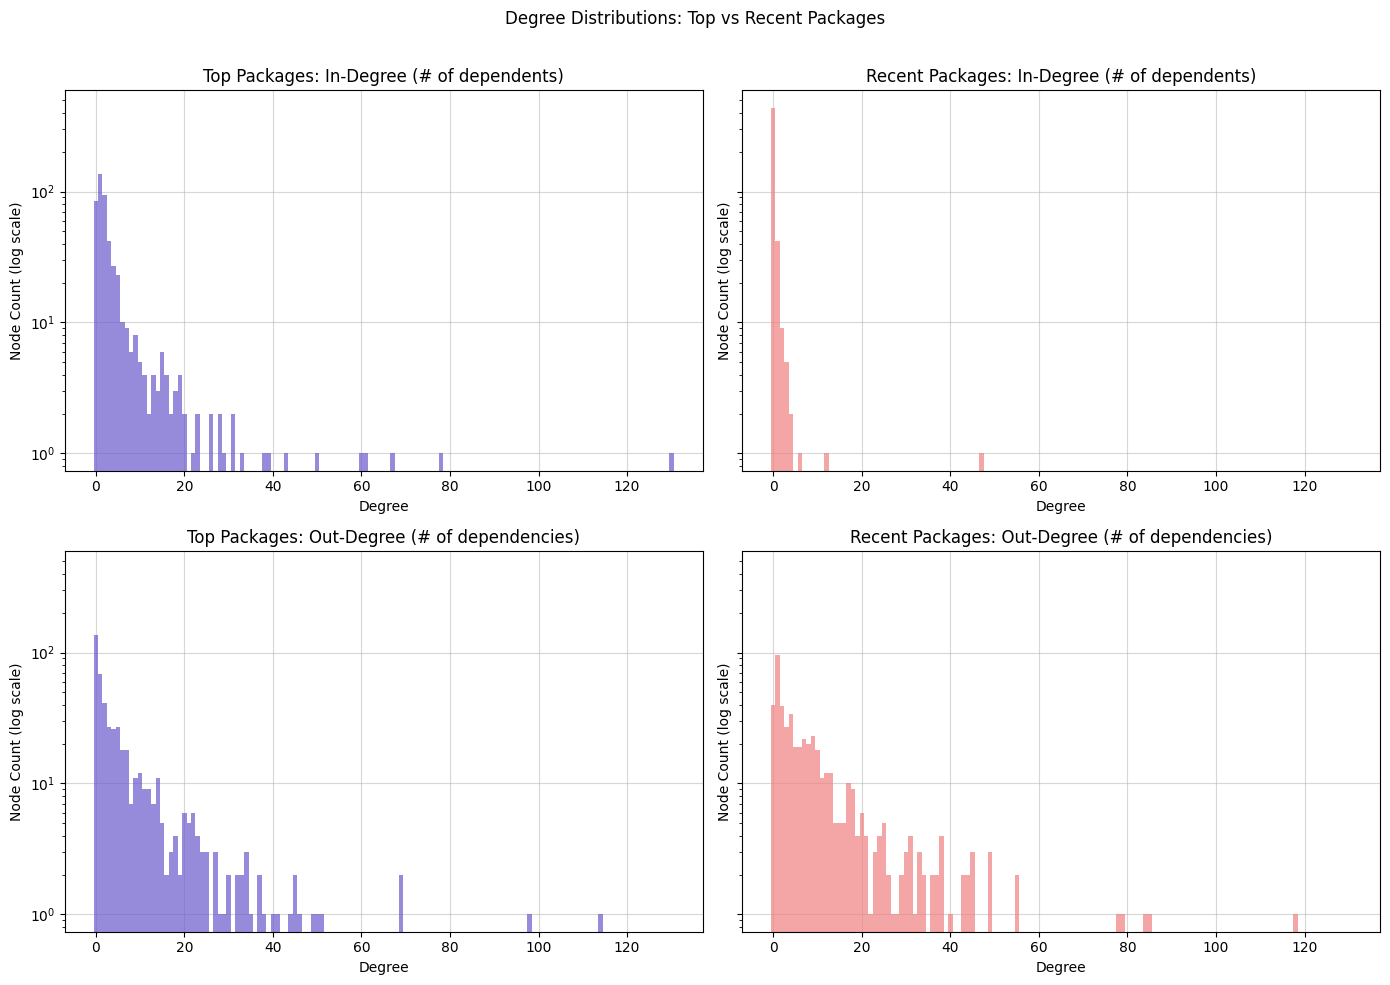

In [18]:
def plot_degree_comparison_core_only(G_top, G_recent, color_top, color_recent, title_prefix=""):
    def degree_lists_core(G):
        # Only include nodes where core=True
        core_nodes = [n for n, d in G.nodes(data=True) if d.get("is_core", False)]
        in_deg = [G.in_degree(n) for n in core_nodes]
        out_deg = [G.out_degree(n) for n in core_nodes]
        return in_deg, out_deg

    in_deg_top, out_deg_top = degree_lists_core(G_top)
    in_deg_recent, out_deg_recent = degree_lists_core(G_recent)

    # Combine all degrees to get global min/max for binning
    all_degrees = in_deg_top + in_deg_recent + out_deg_top + out_deg_recent
    if not all_degrees:
        print("No core nodes found in either graph.")
        return
    deg_min, deg_max = min(all_degrees), max(all_degrees)
    bins = np.arange(deg_min, deg_max + 2) - 0.5  # so each integer is its own bin

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

    # Prepare data and labels for each subplot to avoid repetition
    plot_configs = [
        # (row, col, data, color, title)
        (0, 0, in_deg_top, color_top, "Top Packages: In-Degree (# of dependents)"),
        (0, 1, in_deg_recent, color_recent, "Recent Packages: In-Degree (# of dependents)"),
        (1, 0, out_deg_top, color_top, "Top Packages: Out-Degree (# of dependencies)"),
        (1, 1, out_deg_recent, color_recent, "Recent Packages: Out-Degree (# of dependencies)"),
    ]

    for row, col, data, color, title in plot_configs:
        ax = axes[row, col]
        ax.hist(data, bins=bins, color=color, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Degree")
        ax.set_ylabel("Node Count (log scale)")
        ax.set_yscale("log")
        add_grid(ax, "y")
        add_grid(ax, "x")

    plt.suptitle(title_prefix)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_degree_comparison_core_only(
    G_top, G_recent, color_top, color_recent,
    title_prefix="Degree Distributions: Top vs Recent Packages"
)

> While number of dependencies looks as uninteresting as before, the number of dependents does not. Top packages unsurprisingly have more dependents, and this may be another indicator of less cause for suspicion.

### Clustering Coefficient

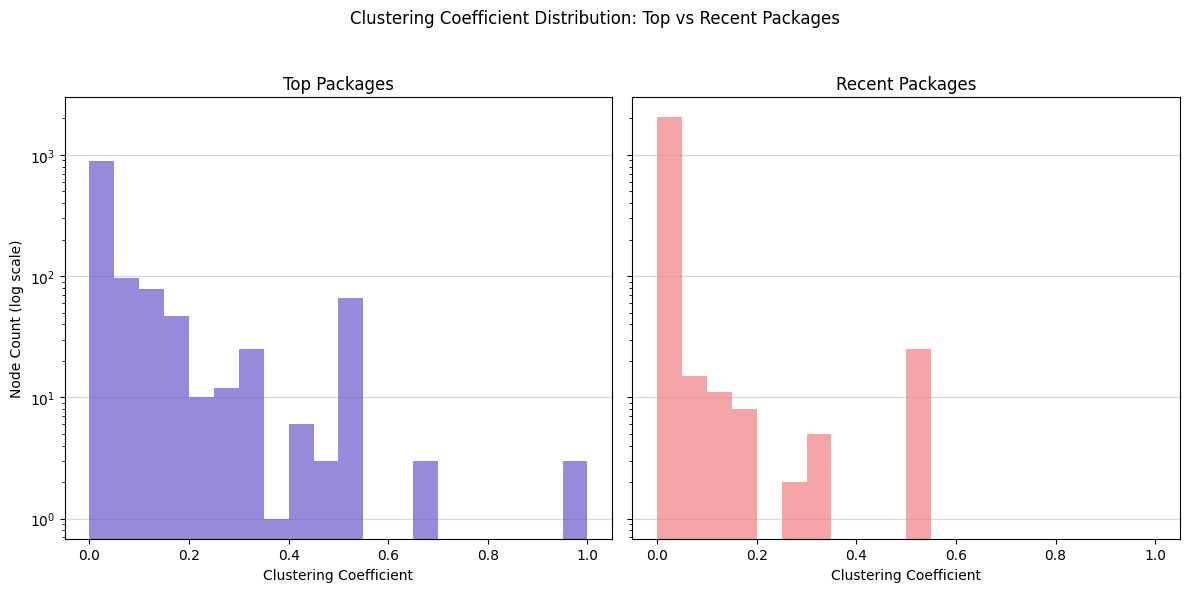

In [19]:
# Compute clustering coefficients for each node in both graphs
clustering_top = nx.clustering(G_top)
clustering_recent = nx.clustering(G_recent)

# Extract coefficient values
coeffs_top = list(clustering_top.values())
coeffs_recent = list(clustering_recent.values())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
bins = np.linspace(0, 1, 21)

axes[0].hist(coeffs_top, bins=bins, alpha=0.7, color=color_top)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Clustering Coefficient")
axes[0].set_ylabel("Node Count (log scale)")
axes[0].set_yscale("log")
add_grid(axes[0], "y")

axes[1].hist(coeffs_recent, bins=bins, alpha=0.7, color=color_recent)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Clustering Coefficient")
axes[1].set_yscale("log")
add_grid(axes[1], "y")

plt.suptitle("Clustering Coefficient Distribution: Top vs Recent Packages")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> A higher clustering coefficient marks a bigger player in the ecosystem.

### Centrality Measures

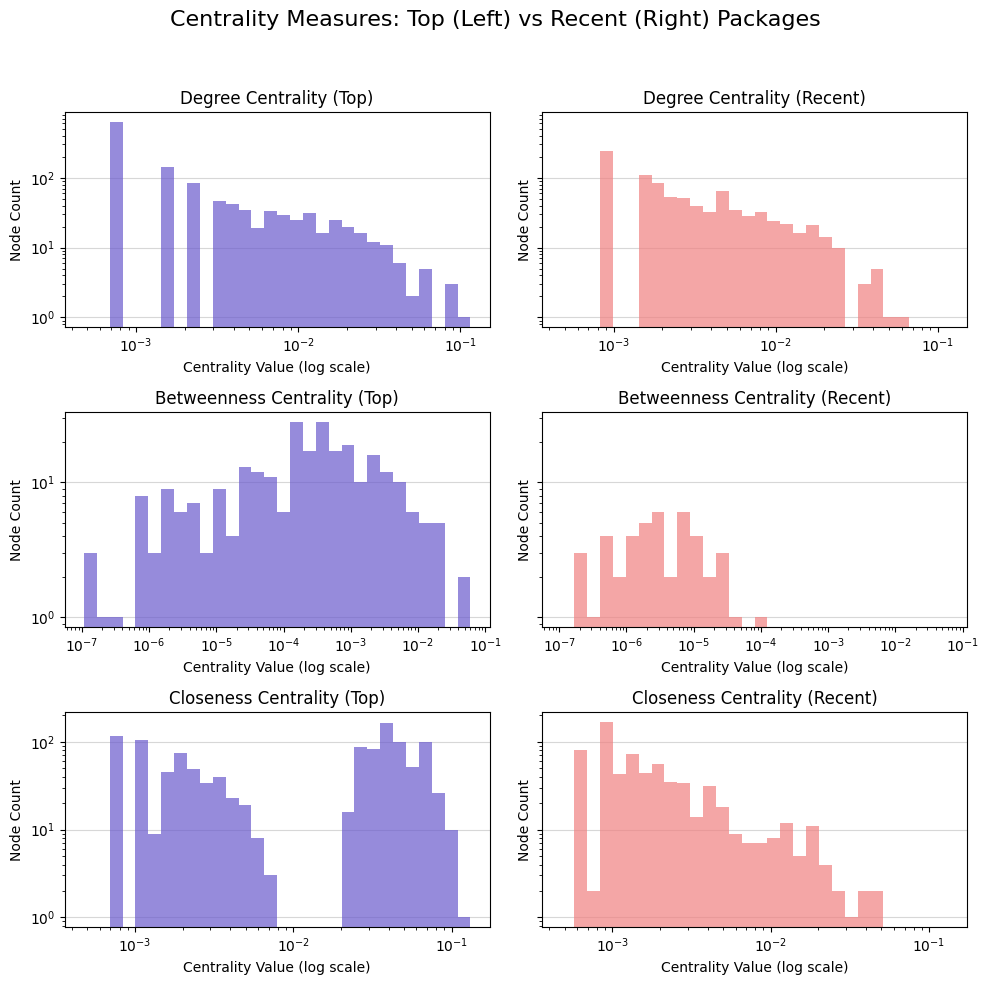

In [20]:
degree_top = nx.degree_centrality(G_top)
degree_recent = nx.degree_centrality(G_recent)

betweenness_top = nx.betweenness_centrality(G_top)
betweenness_recent = nx.betweenness_centrality(G_recent)

closeness_top = nx.closeness_centrality(G_top)
closeness_recent = nx.closeness_centrality(G_recent)

centrality_measures = [
    ("Degree", degree_top, degree_recent),
    ("Betweenness", betweenness_top, betweenness_recent),
    ("Closeness", closeness_top, closeness_recent),
]

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey='row', sharex="row")

for i, (name, top_dict, recent_dict) in enumerate(centrality_measures):
    top_vals = np.array(list(top_dict.values()))
    recent_vals = np.array(list(recent_dict.values()))
    top_vals = top_vals[top_vals > 0]
    recent_vals = recent_vals[recent_vals > 0]

    all_values = np.concatenate([top_vals, recent_vals])
    if all_values.size == 0:
        bins = 10
    else:
        min_val = all_values.min()
        max_val = all_values.max()
        if min_val == max_val:
            bins = 10
        else:
            # Use logspace for bins
            bins = np.logspace(np.log10(min_val), np.log10(max_val), 31)

    # Left column: Top
    axes[i, 0].hist(
        top_vals, bins=bins, alpha=0.7, color=color_top
    )
    axes[i, 0].set_title(f"{name} Centrality (Top)")
    axes[i, 0].set_xlabel("Centrality Value (log scale)")
    axes[i, 0].set_ylabel("Node Count")
    axes[i, 0].set_yscale("log")
    axes[i, 0].set_xscale("log")
    add_grid(axes[i, 0], "y")

    # Right column: Recent
    axes[i, 1].hist(
        recent_vals, bins=bins, alpha=0.7, color=color_recent
    )
    axes[i, 1].set_title(f"{name} Centrality (Recent)")
    axes[i, 1].set_xlabel("Centrality Value (log scale)")
    axes[i, 1].set_ylabel("Node Count")
    axes[i, 1].set_xscale("log")
    axes[i, 1].set_yscale("log")
    add_grid(axes[i, 1], "y")

plt.suptitle("Centrality Measures: Top (Left) vs Recent (Right) Packages", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


> Betweenness centrality represents a night and day difference between top and recent packages. This is somewhat unsurprising, but it is intuitive that more isolated packages may be cause for greater concern.
>
> Closeness centrality is very odd; top packages have a clearly bimodal distribution while recent packages do not. While further efforts would be needed to confirm this, the explanation may lie in the differences between broadly used top packages and nicher/specialized top packages.
>
> Degree centrality is largely uninteresting.
>
> The main story here is that recent packages are consumers and not providers.

### Community Detection and Outliers

> This metric describes how much a given project is connected to nodes within its 'neighborhood' as opposed to outside of it; a higher ratio indicates more dependencies outside while a lower ratios indicates the opposite.

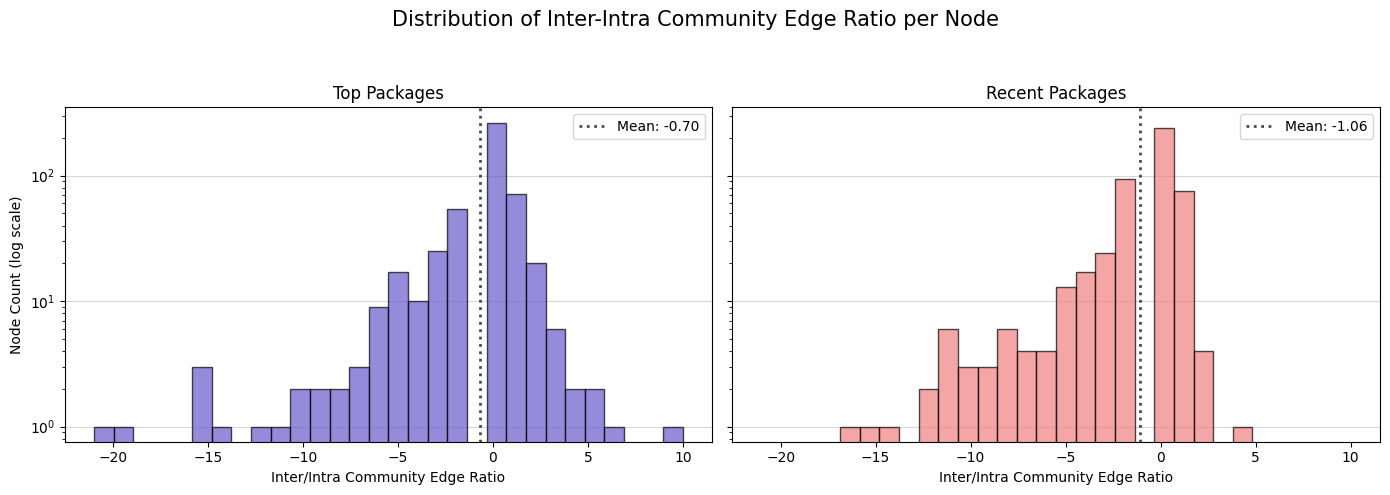

In [94]:
def compute_inter_intra_ratios(
    G, absolute=False, standardize=False, square=False, mean_center=False, log=False
):
    comms = list(greedy_modularity_communities(G))
    node2comm = {n: i for i, c in enumerate(comms) for n in c}
    ratios = []
    node_names = []
    # Only use nodes where is_core=True
    core_nodes = [n for n in G.nodes() if G.nodes[n].get("is_core", False)]
    for node in core_nodes:
        comm = node2comm.get(node)
        if comm is None:
            continue
        intra = sum(node2comm.get(nb) == comm for nb in G.neighbors(node))
        inter = sum(node2comm.get(nb) != comm for nb in G.neighbors(node))
        if log:
            if intra == 0 and inter > 0:
                val = np.log(inter + 1)
            elif inter == 0 and intra > 0:
                val = -np.log(intra + 1)
            elif intra > 0 and inter > 0:
                val = np.log(inter / intra)
            else:
                val = 0
        else:
            if intra == 0 and inter > 0:
                val = inter + 1
            elif inter == 0 and intra > 0:
                val = -(intra + 1)
            elif intra > 0 and inter > 0:
                val = inter / intra
            else:
                val = 0
        ratios.append(val)
        node_names.append(node)
    ratios = np.array(ratios)
    if mean_center:
        ratios -= np.mean(ratios)
    if standardize:
        std = np.std(ratios)
        ratios = (ratios - np.mean(ratios)) / std if std > 0 else ratios - np.mean(ratios)
    if absolute:
        ratios = np.abs(ratios)
    if square:
        ratios = np.square(ratios)
    return ratios, node_names

def plot_inter_intra_ratios(
    G_top, G_recent, color_top, color_recent, title="",
    absolute=False, standardize=False, square=False, mean_center=False, log=False
):
    log_ratios_and_nodes = [
        compute_inter_intra_ratios(G, absolute, standardize, square, mean_center, log=log)
        for G in (G_top, G_recent)
    ]
    log_ratios = [item[0] for item in log_ratios_and_nodes]
    all_logs = np.concatenate(log_ratios)
    bins = np.linspace(all_logs.min(), all_logs.max(), 31) if all_logs.size else 10
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    subtitles = ["Top Packages", "Recent Packages"]
    colors = [color_top, color_recent]
    for ax, vals, color, subtitle in zip(axes, log_ratios, colors, subtitles):
        mean_val = np.mean(vals) if len(vals) else 0
        ax.hist(vals, bins=bins, color=color, edgecolor="k", alpha=0.7)
        ax.axvline(mean_val, color="black", linestyle=":", linewidth=2, label=f"Mean: {mean_val:.2f}", alpha=0.7)
        if log:
            xlabel = "log(Inter/Intra Community Edge Ratio)"
        else:
            xlabel = "Inter/Intra Community Edge Ratio"
        if standardize:
            xlabel = "Standardized " + xlabel
        if mean_center:
            xlabel = "Mean-centered " + xlabel
        if square:
            xlabel = "Squared " + xlabel
        elif absolute:
            xlabel = "Absolute " + xlabel
        ax.set_xlabel(xlabel)
        ax.set_title(subtitle)
        ax.set_yscale("log")
        add_grid(ax, "y")
        ax.legend()
    axes[0].set_ylabel("Node Count (log scale)")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

plot_inter_intra_ratios(
    G_top, G_recent, color_top, color_recent,
    title="Distribution of Inter-Intra Community Edge Ratio per Node",
)

> These distributions are somewhat similar, but top packages seem to have greater extremes (ie lower kurtosis). It may be worth to center around 0 and take the square the values to exaggerate extrema.

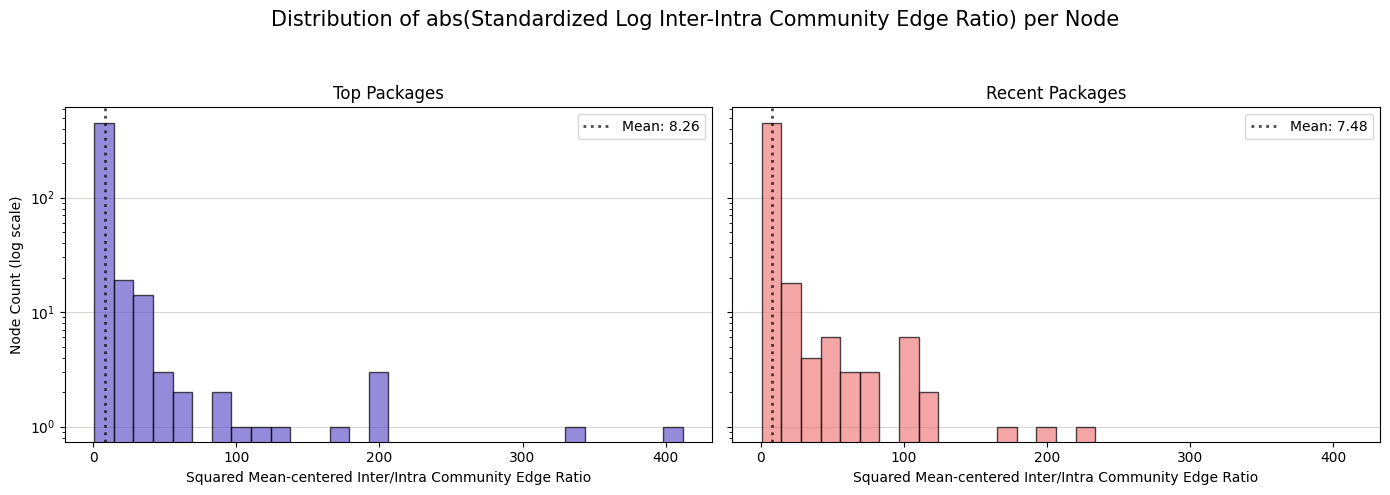

In [95]:
plot_inter_intra_ratios(G_top, G_recent, color_top, color_recent, square=True, mean_center=True,
                            title="Distribution of abs(Standardized Log Inter-Intra Community Edge Ratio) per Node")

> This would potentially have some utility in identifying top packages at the extreme, but it may also be redundant with other popularity/SourceRank metrics. Let's take a look.

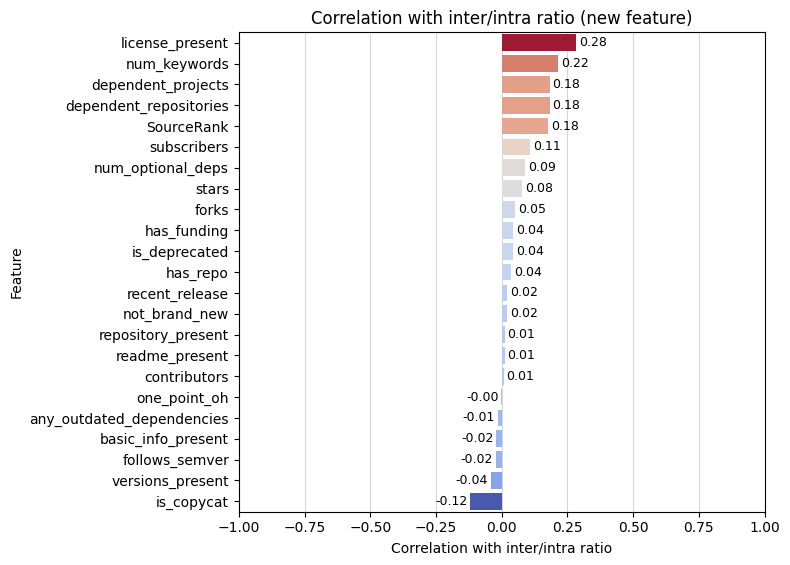

In [112]:
def plot_corr_with_new_feature(ratios, df_nodes, ratios_names=None, palette="coolwarm"):
    # Merge ratios into df_nodes
    if ratios_names is not None:
        df_corr = pd.merge(
            df_nodes, 
            pd.DataFrame({"name": ratios_names, "inter_intra_ratio": ratios}),
            on="name", how="inner"
        )
    else:
        df_corr = df_nodes.copy()
        df_corr["inter_intra_ratio"] = ratios

    # Numeric columns, convert bools to int
    numeric_cols = df_corr.select_dtypes(include=["number", "bool"]).copy()
    for col in numeric_cols.select_dtypes(include="bool"):
        numeric_cols[col] = numeric_cols[col].astype(int)
    corr = numeric_cols.corr().dropna(axis=0, how="all").dropna(axis=1, how="all")

    # Correlation with new feature
    if "inter_intra_ratio" not in corr.columns:
        raise ValueError("inter_intra_ratio not found in correlation matrix.")
    corr_with_new = corr["inter_intra_ratio"].drop("inter_intra_ratio", errors="ignore").sort_values(ascending=False)

    # Barplot with palette/hue
    plt.figure(figsize=(8, max(2, len(corr_with_new) * 0.25)))
    # Use hue to color bars by value, and avoid deprecated get_cmap
    norm = plt.Normalize(-1, 1)
    # Create a DataFrame for plotting with hue
    plot_df = pd.DataFrame({
        "Feature": corr_with_new.index,
        "Correlation": corr_with_new.values
    })
    # Add a column for coloring (hue)
    plot_df["CorrColor"] = plot_df["Correlation"]

    ax = sns.barplot(
        data=plot_df,
        x="Correlation",
        y="Feature",
        orient="h",
        hue="CorrColor",
        palette=palette,
        dodge=False
    )
    # Remove the legend for hue (since it's just a color gradient)
    ax.legend_.remove() if ax.legend_ is not None else None
    ax.set(xlabel="Correlation with inter/intra ratio", ylabel="Feature", title="Correlation with inter/intra ratio (new feature)")
    add_grid(ax, "x")
    for i, v in enumerate(corr_with_new.values):
        ax.text(
            v + 0.01 if v >= 0 else v - 0.01,
            i,
            f"{v:.2f}",
            color="black",
            va="center",
            ha="left" if v >= 0 else "right",
            fontsize=9
        )
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()

ratios_top, ratios_names_top = compute_inter_intra_ratios(G_top)
plot_corr_with_new_feature(ratios_top, df_nodes_top, ratios_names=ratios_names_top)

> There is not any major colinearity, but there is also only weak relationships with other features (including SourceRank). It is unclear how useful such a feature would be.
>
> Let's check how the other structural feature fare.

### SourceRank/Structure Feature Comparison

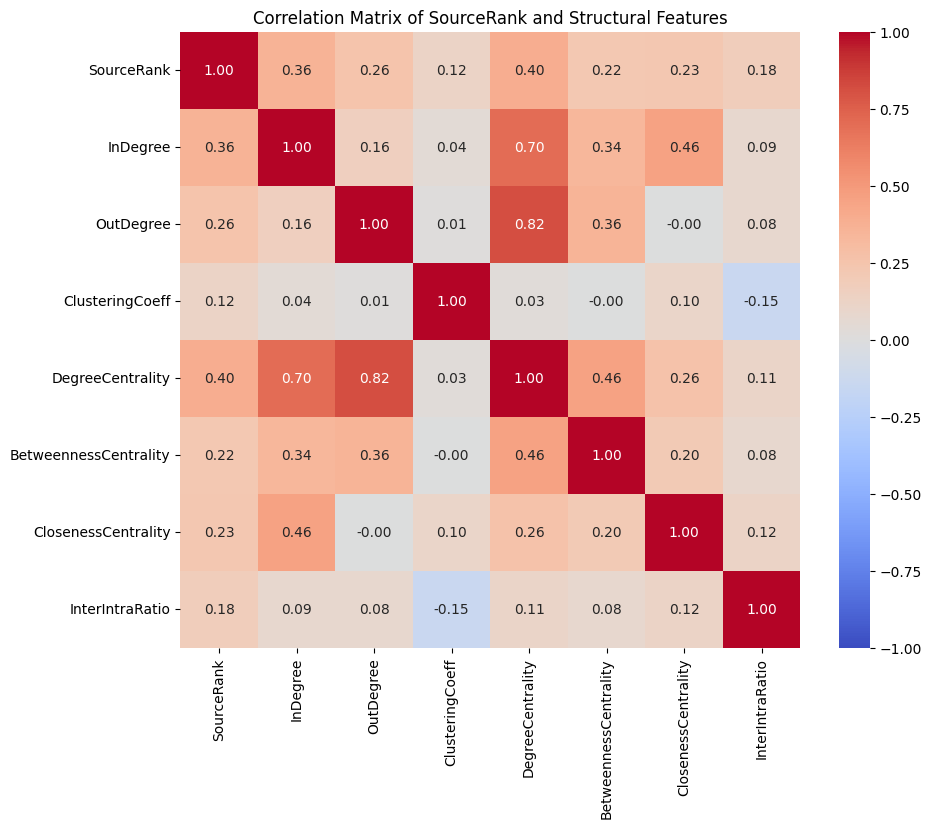

In [115]:
def plot_sourcerank_structural_features(
    G, degree_centrality=None, betweenness=None,
    closeness=None, clustering=None, inter_intra_ratios=None
):
    nodes = list(G.nodes())
    get_val = lambda d, n, i: (d.get(n, np.nan) if isinstance(d, dict) else (d[i] if d is not None and i < len(d) else np.nan))
    data = [{
        "SourceRank": G.nodes[n].get("SourceRank", np.nan),
        "InDegree": G.in_degree(n) if hasattr(G, "in_degree") else np.nan,
        "OutDegree": G.out_degree(n) if hasattr(G, "out_degree") else np.nan,
        "ClusteringCoeff": get_val(clustering, n, i),
        "DegreeCentrality": get_val(degree_centrality, n, i),
        "BetweennessCentrality": get_val(betweenness, n, i),
        "ClosenessCentrality": get_val(closeness, n, i),
        "InterIntraRatio": (
            inter_intra_ratios.get(n, np.nan) if isinstance(inter_intra_ratios, dict)
            else (inter_intra_ratios[i] if inter_intra_ratios is not None and i < len(inter_intra_ratios) else np.nan)
        )
    } for i, n in enumerate(nodes)]
    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df.corr(),
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1, vmax=1
    )
    plt.title("Correlation Matrix of SourceRank and Structural Features")
    plt.show()

    return df

df_scatter_top = plot_sourcerank_structural_features(
    G_top,
    degree_centrality=degree_top,
    betweenness=betweenness_top,
    closeness=closeness_top,
    clustering=clustering_top,
    inter_intra_ratios=ratios_top,
)

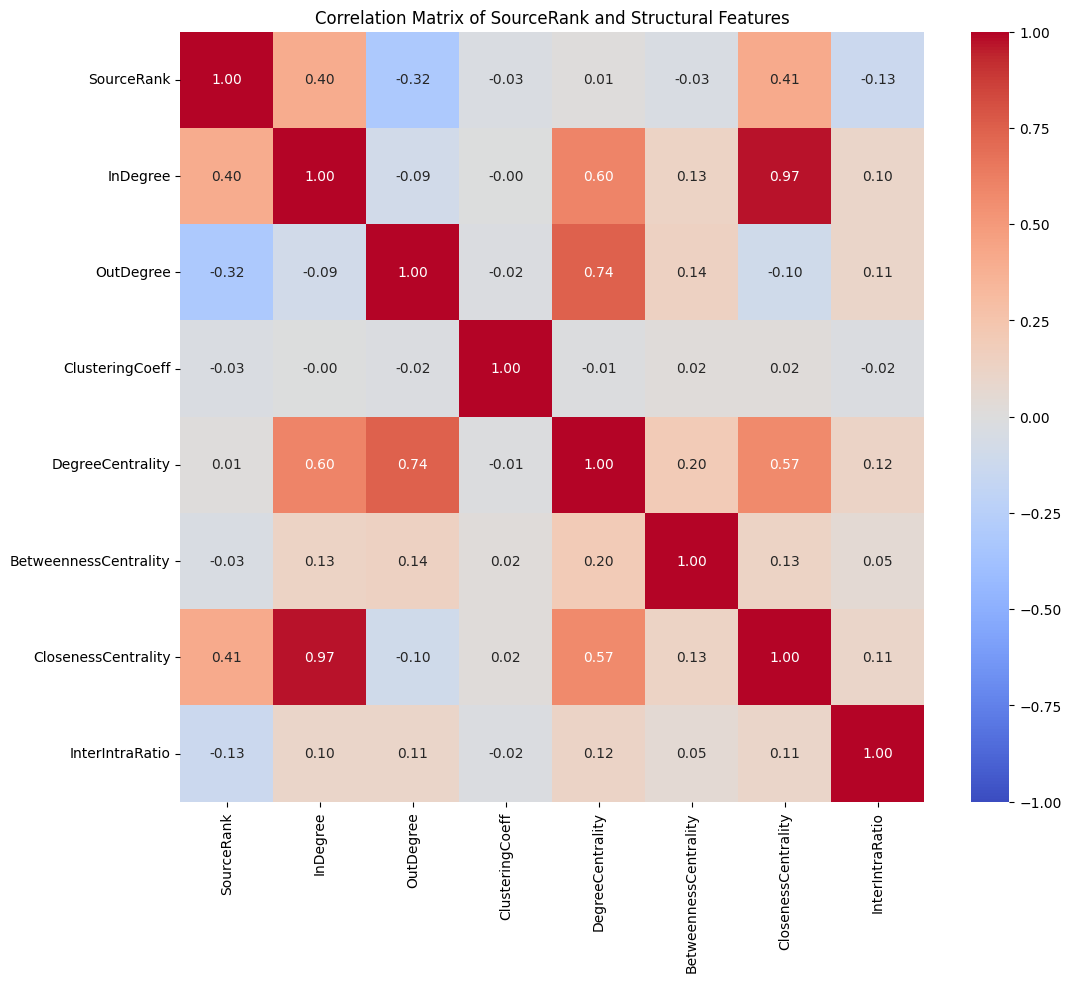

In [114]:
df_scatter_recent = plot_sourcerank_structural_features(
    G_recent,
    degree_centrality=degree_recent,
    betweenness=betweenness_recent,
    closeness=closeness_recent,
    clustering=clustering_recent,
    inter_intra_ratios=ratios_recent,
)

> In-degree, out-degree, and closeness centrality seem interesting in their more moderate correlations with SourceRank. However, these still don't look particularly strong on their own.

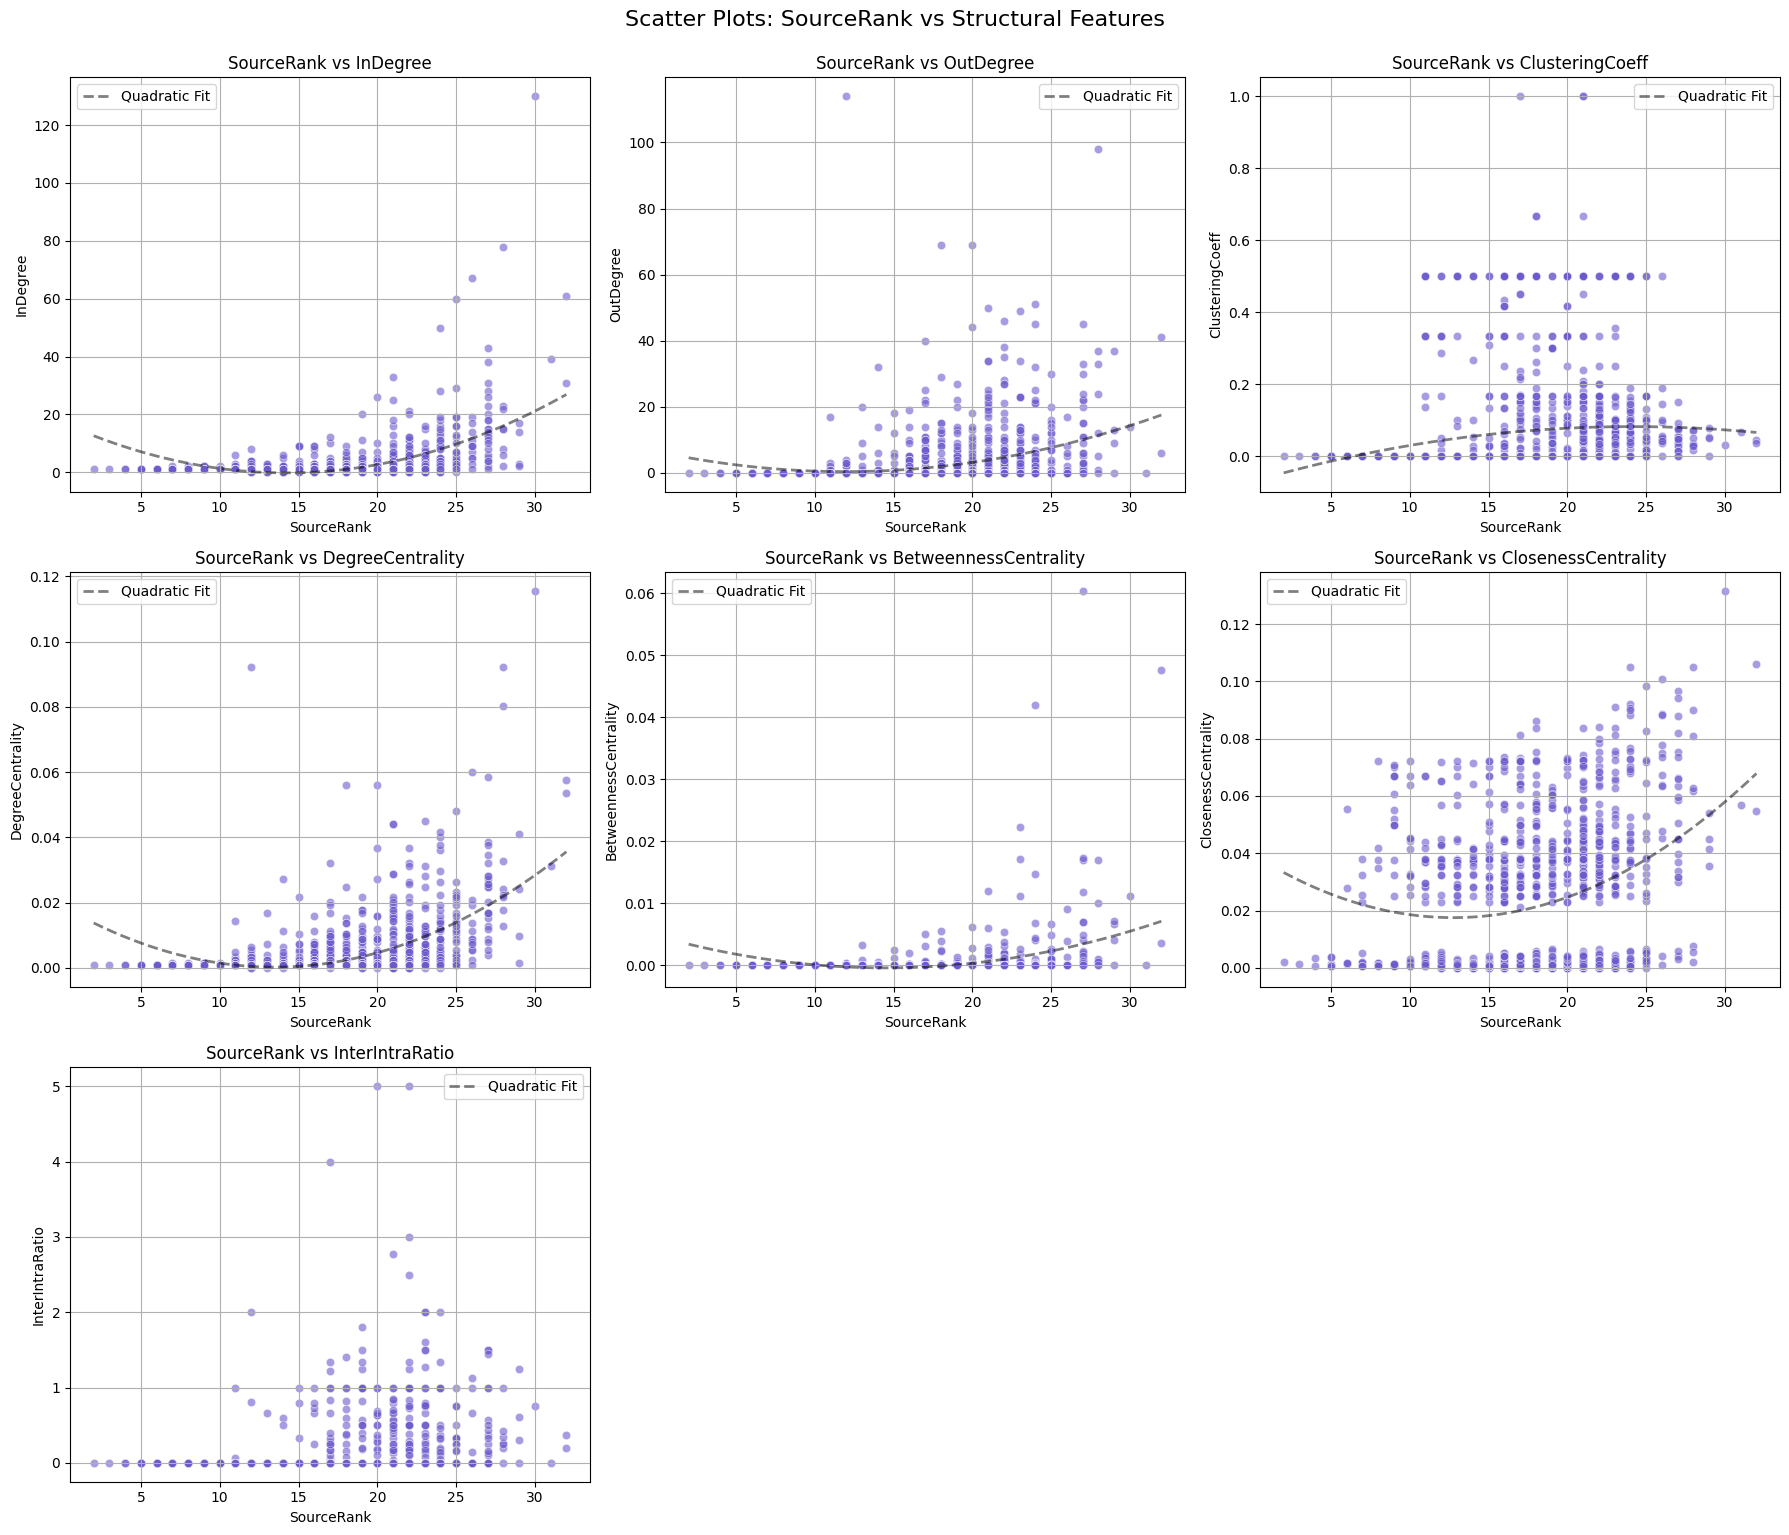

In [24]:
def plot_sourcerank_scatter_matrix(df, color):
    features = [
        "InDegree", "OutDegree", "ClusteringCoeff", "DegreeCentrality",
        "BetweennessCentrality", "ClosenessCentrality", "InterIntraRatio"
    ]
    n_cols = 3
    n_rows = int(np.ceil(len(features)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.scatterplot(x="SourceRank", y=feature, data=df, ax=axes[i], alpha=0.6, color=color)
        # Fit and plot 2nd degree polynomial
        x = df["SourceRank"].values
        y = df[feature].values
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 2:
            coeffs = np.polyfit(x[mask], y[mask], 2)
            poly = np.poly1d(coeffs)
            x_fit = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 200)
            y_fit = poly(x_fit)
            axes[i].plot(x_fit, y_fit, color="black", linestyle="--", linewidth=2, alpha=0.5, label="Quadratic Fit")
            axes[i].legend()
        axes[i].set_title(f"SourceRank vs {feature}")
        axes[i].grid(True)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.suptitle("Scatter Plots: SourceRank vs Structural Features", y=1.02, fontsize=16)
    plt.show()

plot_sourcerank_scatter_matrix(df_scatter_top, color_top)

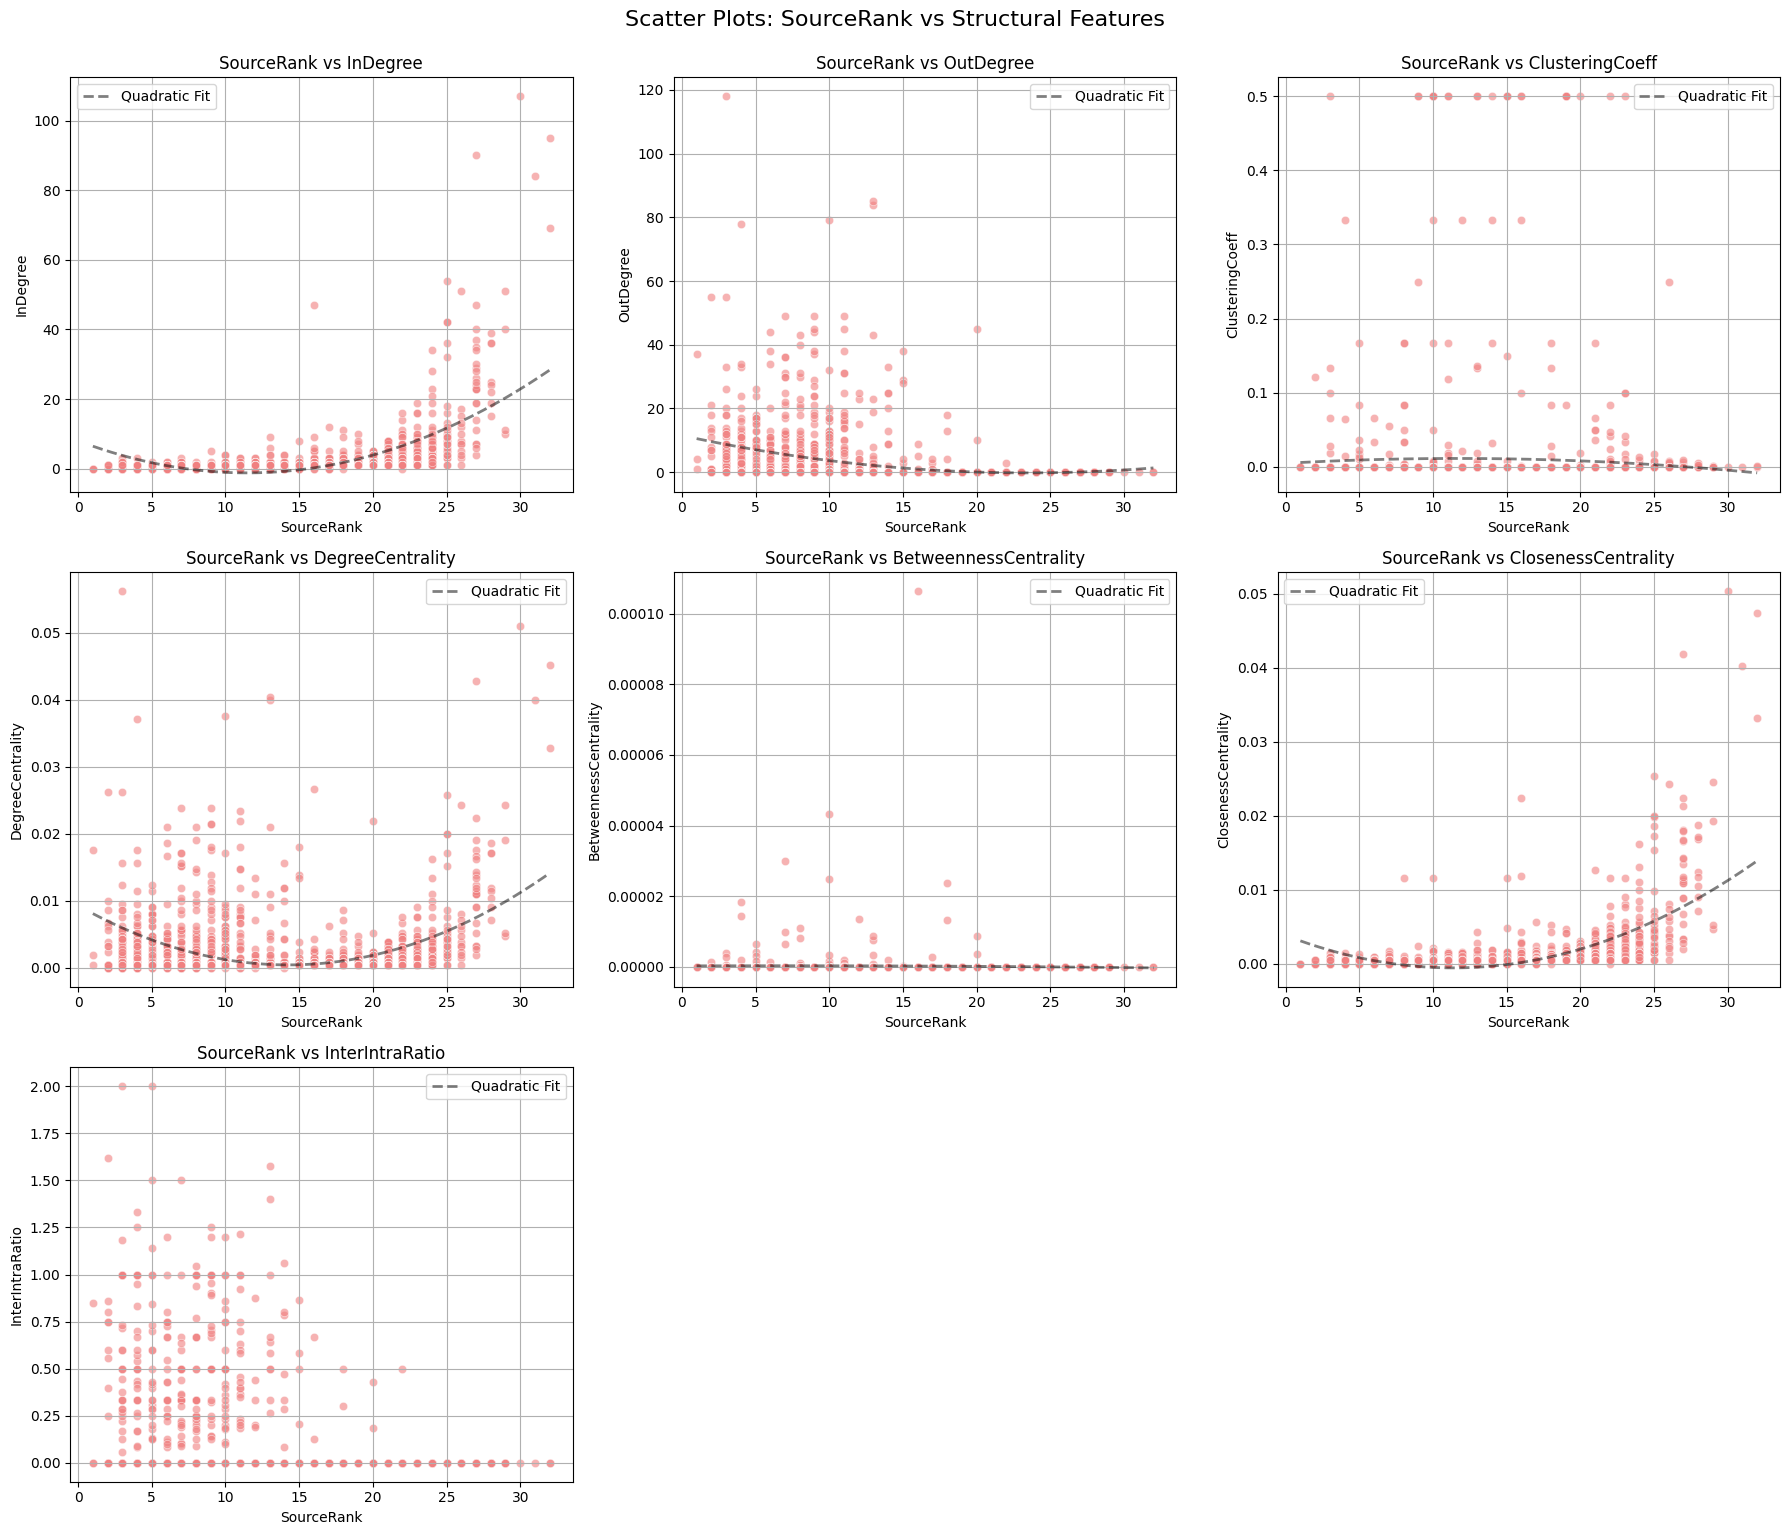

In [25]:
plot_sourcerank_scatter_matrix(df_scatter_recent, color_recent)

> This also highlights the potential relevance of in-degree and out-degree as well as closeness centrality. Degree centrality is interesting but a bit less consistent.
>
> These also show a bit of the non-linearity of these relationships. Bimodality has also made another appearance for top packages in the case of closeness centrality.

## **Summary**

### Notes

* Node features
  * Popularity metrics are better used as filtering mechanisms after standardizing anomaly scores
    * They may also benefit from log reciprocal transformations
  * Stars and forks as well as repository_present and readme_present are redundant
  * Binary repo copycat feature may be useful
* Edge features
  * Proportion of optional dependencies per package may also be a useful feature
* Structural features
  * In-degree/number of dependents may be useful
  * Out-degree/number of dependencies looks somewhat useful, but less so
  * Closeness centrality looks to be the most relevant (tested) measure

### Takeaways

* Effort should be made to ensure 'anomaly' means reasons for suspicion
  * Popular, well-established repos are frequently the statistical outliers
* Anomaly detection may be done in following steps:
  1. Compute score with features that offer reason to find a project suspicious (ex. SourceRank metrics, graph structure)
  2. Normalize scores
  3. Apply filtering with features that are negative indicators (ex. popularity, number of contributors)
* Feature engineering:
  * Consolidate stars/forks and repository_present/readme_present
  * Create binary copycat feature
  * Create proportion of dependencies that are optional
  * Create structural features